### **Description**

This recipe shows how to calculate the Atlantic Meridional Overturning Circulation (AMOC) stream function in potential density-coordinates using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using JRA55-do from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

---
### **Background**
The diapycnal overturning stream function is routinely used to characterise the strength and structure of the AMOC in density-space (e.g., $\sigma_{0}$ or $\sigma{2}$) as a function of latitude $\phi$ and can be defined at time $t$ as follows:

$$\Psi_{\sigma_{0}}(\phi, \sigma_{0}, t) = \int_{x_w}^{x_e} \int_{z(\lambda, \phi, \sigma_{0})}^{\eta} v(\lambda, \phi, z', t) \ dz' \ dx$$

where the meridional velocity $v(\lambda, \phi, z, t)$ is first accumulated vertically from the sea surface $\eta$ to a specified isopycnal depth $z(\lambda, \phi, \sigma_{0})$ (decreasing downward) before being integrated zonally between the western $x_w$ and eastern $x_e$ boundaries of the basin.

---

In [1]:
# -- Import required packages -- #
import gsw
import numpy as np
import xarray as xr
from nemo_cookbook import NEMODataTree

xr.set_options(display_style="text")

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

Note that, although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import os
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': f"{os.getcwd()}/dask_tmp",
                 'local_directory': f"{os.getcwd()}/dask_tmp"
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=3, memory_limit='5GB')
client = Client(cluster)
client

### **Accessing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 NEMO model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [ ]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain"

# Open eORCA1 NEMO model domain_cfg:
ds_domain = (xr.open_zarr(f"{domain_filepath}/domain_cfg", consolidated=True, chunks={})
             .squeeze()
             .rename({'z': 'nav_lev'})
             )
ds_subbasins = xr.open_zarr(f"{domain_filepath}/subbasins", consolidated=True, chunks={})

ds_domain

<xarray.Dataset> Size: 667MB
Dimensions:        (t: 1, y: 331, x: 360, z: 75)
Dimensions without coordinates: t, y, x, z
Data variables: (12/54)
    e1t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2v            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bottom_level   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2u            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bathy_metry    (t, y, x) float32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ...             ...
    nav_lev        (z) float32 300B dask.array<chunksize=(75,), meta=np.ndarray>
    mask_csundef   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    nav_lat        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter   (t) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    top_level      (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    DOMAIN_number_total:     1
    DOMAIN_number:           0
    DOMAIN_dimensions_ids:   [1, 2]
    DOMAIN_size_global:      [362, 332]
    DOMAIN_size_local:       [362, 332]
    DOMAIN_position_first:   [1, 1]
    DOMAIN_position_last:    [362, 332]
    DOMAIN_halo_size_start:  [0, 0]
    DOMAIN_halo_size_end:    [0, 0]
    DOMAIN_type:             BOX
    history:                 Mon Jun  5 12:41:32 2023: ncks -A mask.nc ORCA1_...
    NCO:                     4.4.7

**Next, we need to import the conservative temperature and absolute salinity stored at T-points in a single dataset.**

**Typically, NEMO model outputs defined on T-grid points are stored together in netCDF files. In this case, you can replace `xr.merge()` with a single call to xarray's `open_dataset()` function passing the file path to your `_gridT.nc` file(s).**

In [3]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/T1y"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridT = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['thetao_con', 'so_abs']], compat="override")
ds_gridT = ds_gridT.sel(time_counter=slice("1976-01", "2023-12"))

# Calculate potential density anomaly referenced to the sea surface (kg/m3):
ds_gridT['sigma0'] = gsw.density.sigma0(CT=ds_gridT['thetao_con'], SA=ds_gridT['so_abs'])
ds_gridT['sigma0'].name = 'sigma0'

ds_gridT

<xarray.Dataset> Size: 7GB
Dimensions:        (deptht: 75, y: 331, x: 360, time_counter: 48)
Coordinates:
  * deptht         (deptht) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
Dimensions without coordinates: y, x
Data variables:
    thetao_con     (time_counter, deptht, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
    so_abs         (time_counter, deptht, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
    sigma0         (time_counter, deptht, y, x) float64 3GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean
    interval_operation:  1 yr
    interval_write:      1 yr
    long_name:           sea_water_conservative_temperature
    online_operation:    average
    standard_name:       sea_water_conservative_temperature
    units:               degC

**Next, we need to import the meridional velocity and vertical grid cell thicknesses stored at V-points in a single dataset.**

**Typically, NEMO model outputs defined on V-grid points are stored together in netCDF files. In this case, you can replace `xr.merge()` with a single call to xarray's `open_dataset()` function passing the file path to your `_gridV.nc` file(s).**

In [4]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/V1y"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridV = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['e3v', 'vo']], compat="override")
ds_gridV = ds_gridV.sel(time_counter=slice("1976-01", "2023-12"))

ds_gridV

<xarray.Dataset> Size: 3GB
Dimensions:        (depthv: 75, y: 331, x: 360, time_counter: 48)
Coordinates:
  * depthv         (depthv) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
Dimensions without coordinates: y, x
Data variables:
    e3v            (time_counter, depthv, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
    vo             (time_counter, depthv, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 3600 s)
    interval_operation:  3600 s
    interval_write:      1 yr
    long_name:           V-cell thickness
    online_operation:    average
    standard_name:       cell_thickness
    units:               m

### **Creating a NEMODataTree**

**Next, let's create a NEMODataTree to store our domain and T- & V-grid variables for the eORCA1 model.**

In [ ]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent": {"domain": ds_domain, "gridT": ds_gridT, "gridV": ds_gridV}}

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 48)
│   Coordinates:
│       time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
│     * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:        (time_counter: 48, k: 75, j: 331, i: 360)
│       Coordinates:
│         * deptht         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
│           time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
│           gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           thetao_con     (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           so_abs         (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           sigma0         (time_counter, k, j, i) float64 3GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           e1t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           top_level      (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           bottom_level   (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           tmask          (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridV
│       Dimensions:        (time_counter: 48, k: 75, j: 331, i: 360)
│       Coordinates:
│         * depthv         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
│           time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
│           gphiv          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamv          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
│         * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           e3v            (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           vo             (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           e1v            (j, i)

### **Calculating the AMOC diapycnal overturning stream function**
**Now we have constructed our `NEMODataTree`, let's calculate the diapycnal overturning stream function.**

In [7]:
# Define Atlantic Ocean basin mask:
atlmask = ds_subbasins['atlmsk'].rename({"x":"i", "y":"j"}).astype(bool)

# Add meridional volume transport [m3/s] to NEMO V-grid - meridional velocity [m/s] * area of meridional grid cell face [m2]:
nemo['/gridV']['volume_transport'] = (nemo['/gridV']['vo'] * nemo.cell_area(grid='/gridV', dim='j'))

# Transform potential density from NEMO T-grid to V-grid using linear interpolation:
nemo['/gridV']['sigma0'] = nemo.transform_scalar_to(grid='/gridT', var='sigma0', to='V')

In [8]:
# Define potential density bins [kg /m3]:
sigma0_bins = np.arange(22, 29, 0.01)

# Compute meridional volume transport in latitude-potential density coords
vt_sigma0_atl = nemo.binned_statistic(grid="/gridV",
                                      vars=["sigma0"],
                                      values="volume_transport",
                                      keep_dims=["time_counter", "j"],
                                      bins=[sigma0_bins],
                                      statistic="nansum",
                                      mask=atlmask
                                      )

vt_sigma0_atl

<xarray.DataArray 'volume_transport' (time_counter: 48, j: 331, sigma0_bins: 699)> Size: 89MB
dask.array<reshape, shape=(48, 331, 699), dtype=float64, chunksize=(48, 331, 699), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-0...
  * j             (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
  * sigma0_bins   (sigma0_bins) float64 6kB 22.01 22.02 22.03 ... 28.98 28.99

**Notice that the resulting DataArray includes a dask array, so we haven't actually computed the diapycnal overturning yet. To do this, we need to call the ``.compute()`` method:**

In [9]:
# Compute diapycnal overturning stream function in Sverdrups [1 Sv = 1E6 m3/s]:
# Here, we accumulate diapycnal volume transports from the lightest to the densest
# isopycnal surface.
moc_sigma0_atl = 1E-6 * vt_sigma0_atl.cumsum(dim='sigma0_bins').compute()
moc_sigma0_atl.name = 'moc_sigma0_atl'

moc_sigma0_atl

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<xarray.DataArray 'moc_sigma0_atl' (time_counter: 48, j: 331, sigma0_bins: 699)> Size: 89MB
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.30921961e-01, -9.30921961e-01, -9.30921961e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.45353998e-01, -9.45353998e-01, -9.45353998e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         -9.51691358e-01, -9.51691358e-01, -9.51691358e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.57064748e-01, -9.57064748e-01, -9.57064748e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.24457492e-03, -1.24457492e-03, -1.24457492e-03, ...,
         -9.02882356e-01, -9.02882356e-01, -9.02882356e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.11390452e-01, -9.11390452e-01, -9.11390452e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],
      shape=(48, 331, 699))
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-0...
  * j             (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
  * sigma0_bins   (sigma0_bins) float64 6kB 22.01 22.02 22.03 ... 28.98 28.99

### **Visualising the time-mean AMOC diapycnal overturning stream function**

**Finally, let's visualise the results by plotting the time-mean Atlantic Meridional Overturning stream function in potential density-coordinates:**

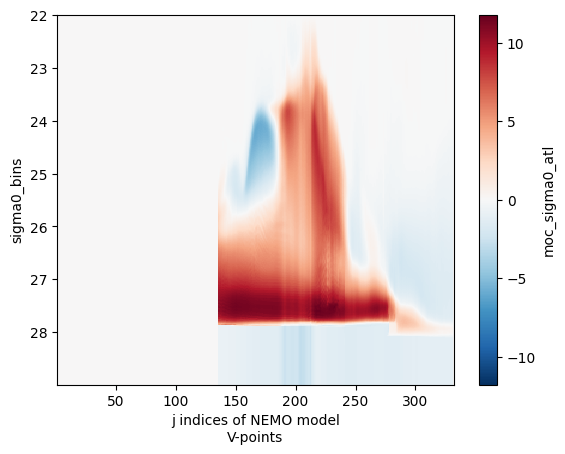

In [10]:
moc_sigma0_atl.mean(dim='time_counter').plot(y='sigma0_bins', yincrease=False)